In [45]:
import warnings
warnings.filterwarnings('ignore')

In [179]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm

In [47]:
# !pip install --upgrade "statsmodels>=0.14"

In [48]:
plt.style.use('ggplot')

In [49]:
cpih = pd.read_csv('CPIHOSSL.csv')
cpih.head()

,observation_date,CPIHOSSL
0,1967-01-01,30.5
1,1967-02-01,30.5
2,1967-03-01,30.5
3,1967-04-01,30.6
4,1967-05-01,30.7


In [50]:
cpih['CPIHOSSL'] = cpih['CPIHOSSL'].astype(float)

In [51]:
cpih['CPIHOSSL_delta'] = cpih['CPIHOSSL'].diff()

In [52]:
cpih['CPIHOSSL_log'] = np.log(cpih['CPIHOSSL'])
cpih['CPIHOSSL_logdelta'] = cpih['CPIHOSSL_log'].diff()

In [53]:
cpih.head()

,observation_date,CPIHOSSL,CPIHOSSL_delta,CPIHOSSL_log,CPIHOSSL_logdelta
0,1967-01-01,30.5,NaN,3.417727,NaN
1,1967-02-01,30.5,0.0,3.417727,0.000000
2,1967-03-01,30.5,0.0,3.417727,0.000000
3,1967-04-01,30.6,0.1,3.421000,0.003273
4,1967-05-01,30.7,0.1,3.424263,0.003263


In [54]:
cpih

,observation_date,CPIHOSSL,CPIHOSSL_delta,CPIHOSSL_log,CPIHOSSL_logdelta
0,1967-01-01,30.500,NaN,3.417727,NaN
1,1967-02-01,30.500,0.000,3.417727,0.000000
2,1967-03-01,30.500,0.000,3.417727,0.000000
3,1967-04-01,30.600,0.100,3.421000,0.003273
4,1967-05-01,30.700,0.100,3.424263,0.003263
...,...,...,...,...,...
699,2025-04-01,344.919,1.627,5.843310,0.004728
700,2025-05-01,345.867,0.948,5.846054,0.002745
701,2025-06-01,346.957,1.090,5.849201,0.003147
702,2025-07-01,347.713,0.756,5.851377,0.002177


In [55]:
cpih['observation_date'] = pd.to_datetime(cpih['observation_date'])

In [56]:
cpih_rec = cpih[cpih['observation_date'] >= pd.to_datetime('2020-01-01')]
cpih_realrec = cpih[cpih['observation_date'] >= pd.to_datetime('2024-01-01')]

Text(0, 0.5, 'CPI for Urban Consumers - Housing')

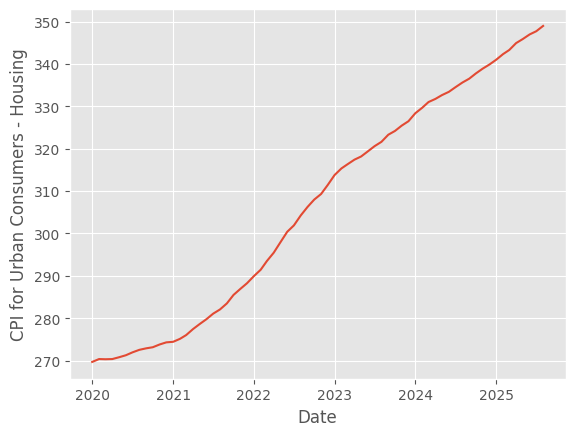

In [57]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL'])
plt.xlabel('Date')
plt.ylabel('CPI for Urban Consumers - Housing')

Text(0, 0.5, 'Monthly Change in CPIHOSSL')

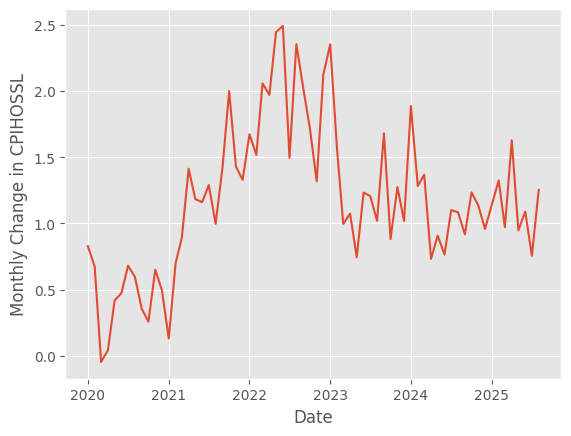

In [58]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL_delta'])
plt.xlabel('Date')
plt.ylabel('Monthly Change in CPIHOSSL')

In [192]:
adf_test = adfuller(cpih['CPIHOSSL_logdelta'][1:].values)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.362305
p-value: 0.012313


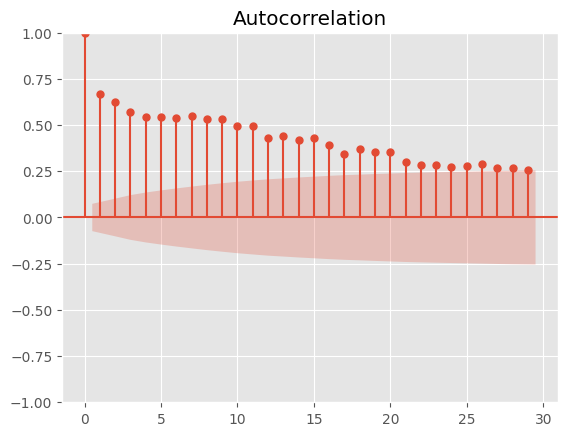

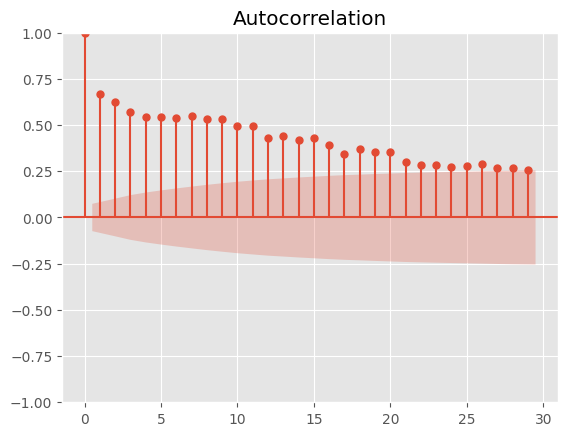

In [59]:
plot_acf(cpih['CPIHOSSL_logdelta'][1:])

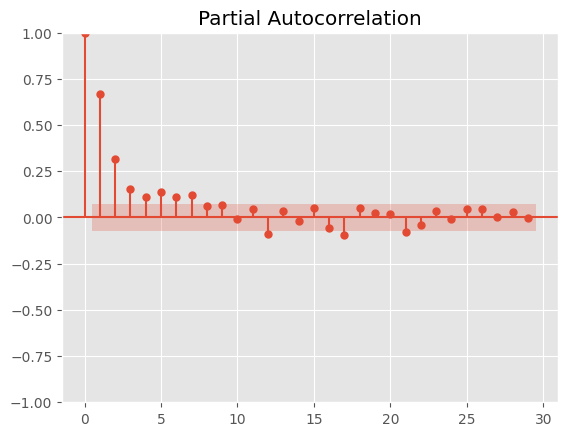

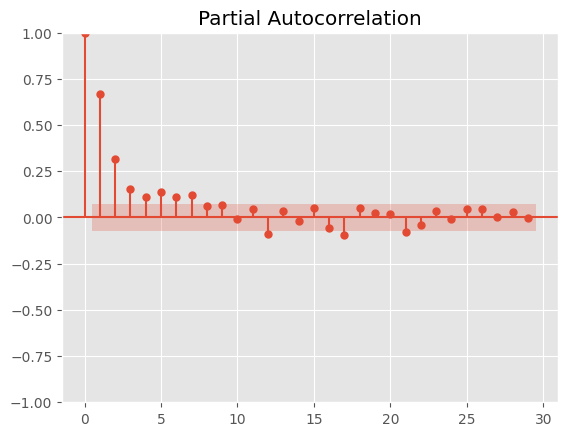

In [60]:
plot_pacf(cpih['CPIHOSSL_logdelta'][1:])

In [61]:
b = 15

In [62]:
end = cpih['CPIHOSSL_logdelta'][1:].values.shape[0] - b
end

688

In [97]:
armod_sm = AutoReg(cpih['CPIHOSSL_logdelta'][1:end].values, lags = 7).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  687
Model:                     AutoReg(7)   Log Likelihood                3231.836
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Sun, 14 Sep 2025   AIC                          -6445.672
Time:                        17:36:43   BIC                          -6404.973
Sample:                             7   HQIC                         -6429.918
                                  687                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.950      0.003       0.000       0.001
y.L1           0.3521      0.038      9.246      0.000       0.277       0.427
y.L2           0.1886      0.040      4.677      0.0

In [99]:
k, n_train = b + 1, cpih['CPIHOSSL_logdelta'][1:end].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00315348, 0.00338378, 0.00346203, 0.0037627 , 0.00356566,
       0.00353887, 0.00335787, 0.00341812, 0.00345436, 0.00348065,
       0.00351785, 0.00350046, 0.00349346, 0.0034754 , 0.00347908,
       0.00348499])

In [101]:
diffs_with_pred = np.append(cpih['CPIHOSSL_logdelta'][1:end].values, fcast_mean)
diffs_with_pred.shape

(703,)

In [103]:
pred_df = pd.DataFrame({'observation_date': cpih['observation_date'][1:], 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1967-02-01,0.000000
1967-03-01,0.000000
1967-04-01,0.003273
1967-05-01,0.003263
1967-06-01,0.000000
...,...
2025-04-01,0.003500
2025-05-01,0.003493
2025-06-01,0.003475


In [105]:
base = np.log(30.5)
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [107]:
pred_df['diffs'][-10:]

observation_date
2024-11-01    0.003358
2024-12-01    0.003418
2025-01-01    0.003454
2025-02-01    0.003481
2025-03-01    0.003518
2025-04-01    0.003500
2025-05-01    0.003493
2025-06-01    0.003475
2025-07-01    0.003479
2025-08-01    0.003485
Name: diffs, dtype: float64

In [109]:
cpih[-10:]

,observation_date,CPIHOSSL,CPIHOSSL_delta,CPIHOSSL_log,CPIHOSSL_logdelta
694,2024-11-01,338.894,1.135,5.825687,0.003355
695,2024-12-01,339.853,0.959,5.828513,0.002826
696,2025-01-01,340.995,1.142,5.831868,0.003355
697,2025-02-01,342.320,1.325,5.835746,0.003878
698,2025-03-01,343.292,0.972,5.838581,0.002835
699,2025-04-01,344.919,1.627,5.843310,0.004728
700,2025-05-01,345.867,0.948,5.846054,0.002745
701,2025-06-01,346.957,1.090,5.849201,0.003147
702,2025-07-01,347.713,0.756,5.851377,0.002177
703,2025-08-01,348.967,1.254,5.854977,0.003600


In [111]:
pred_df = pred_df.reset_index()

In [113]:
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])

In [115]:
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [117]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1967-02-01,0.000000,3.417727,30.500000,NaN
1,1967-03-01,0.000000,3.417727,30.500000,0.000000
2,1967-04-01,0.003273,3.421000,30.600000,0.100000
3,1967-05-01,0.003263,3.424263,30.700000,0.100000
4,1967-06-01,0.000000,3.424263,30.700000,0.000000
...,...,...,...,...,...
698,2025-04-01,0.003500,5.845965,345.836266,1.208469
699,2025-05-01,0.003493,5.849459,347.046545,1.210280
700,2025-06-01,0.003475,5.852934,348.254770,1.208225
701,2025-07-01,0.003479,5.856413,349.468487,1.213717


In [119]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2020-01-01')]

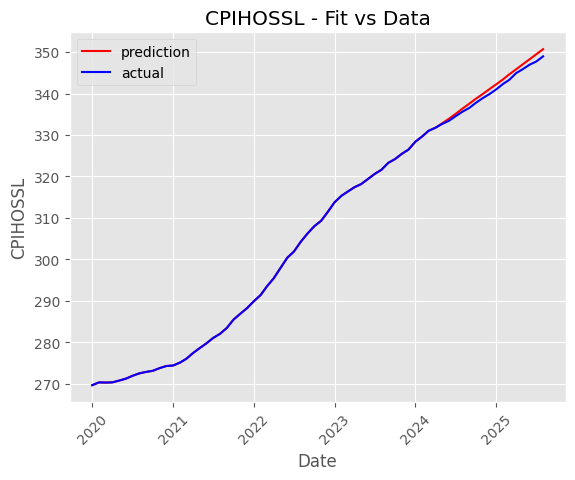

In [121]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('CPIHOSSL')
plt.title('CPIHOSSL - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

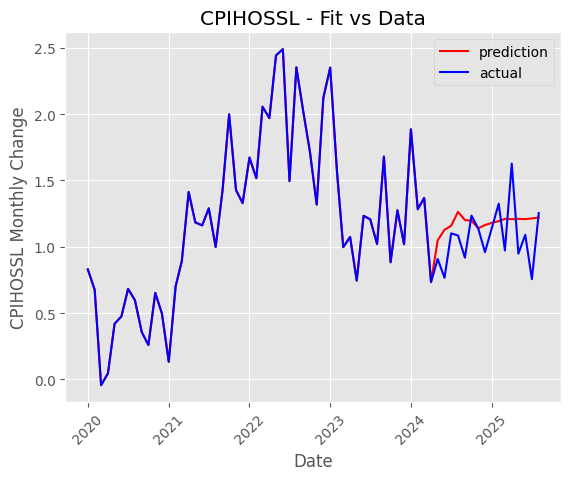

In [123]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL_delta'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('CPIHOSSL Monthly Change')
plt.title('CPIHOSSL - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

### Future Predictions (AR Model)

In [129]:
armod_sm = AutoReg(cpih['CPIHOSSL_logdelta'][1:].values, lags = 7).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  703
Model:                     AutoReg(7)   Log Likelihood                3315.032
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Sun, 14 Sep 2025   AIC                          -6612.065
Time:                        17:37:12   BIC                          -6571.157
Sample:                             7   HQIC                         -6596.247
                                  703                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.988      0.003       0.000       0.001
y.L1           0.3512      0.038      9.336      0.000       0.277       0.425
y.L2           0.1899      0.040      4.768      0.0

In [151]:
# Predictions for future
b = 20
k, n_train = b, cpih['CPIHOSSL_logdelta'][1:].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00333844, 0.00331838, 0.00345376, 0.00323076, 0.00326112,
       0.00319439, 0.00331872, 0.00332364, 0.00333553, 0.00335063,
       0.00333164, 0.00333718, 0.00333719, 0.00335359, 0.00336173,
       0.00336885, 0.00337488, 0.00337731, 0.00338182, 0.00338608])

In [204]:
fcast.conf_int()

array([[-0.00071176,  0.00738863],
       [-0.00097435,  0.00761111],
       [-0.00102254,  0.00793007],
       [-0.00134816,  0.00780968],
       [-0.00138066,  0.0079029 ],
       [-0.00152666,  0.00791545],
       [-0.00148852,  0.00812596],
       [-0.0016372 ,  0.00828449],
       [-0.00172476,  0.00839582],
       [-0.00179456,  0.00849583],
       [-0.00188204,  0.00854532],
       [-0.00193414,  0.00860849],
       [-0.00198962,  0.00866401],
       [-0.00202624,  0.00873341],
       [-0.00207138,  0.00879484],
       [-0.00211151,  0.0088492 ],
       [-0.00214813,  0.00889788],
       [-0.00218381,  0.00893843],
       [-0.00221371,  0.00897735],
       [-0.00224126,  0.00901341]])

In [153]:
start_date = '2025-09-01'
periods = b

dates_fut = pd.date_range(start=start_date, periods=periods, freq='MS')
dates_fut

DatetimeIndex(['2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01',
               '2026-09-01', '2026-10-01', '2026-11-01', '2026-12-01',
               '2027-01-01', '2027-02-01', '2027-03-01', '2027-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [214]:
confint = pd.DataFrame(
    {
        'observation_date': dates_fut,
        'lower_ci_log': fcast.conf_int()[:, 0],
        'upper_ci_log': fcast.conf_int()[:, 1]
    }
)
confint

,observation_date,lower_ci_log,upper_ci_log
0,2025-09-01,-0.000712,0.007389
1,2025-10-01,-0.000974,0.007611
2,2025-11-01,-0.001023,0.007930
3,2025-12-01,-0.001348,0.007810
4,2026-01-01,-0.001381,0.007903
5,2026-02-01,-0.001527,0.007915
6,2026-03-01,-0.001489,0.008126
7,2026-04-01,-0.001637,0.008284
8,2026-05-01,-0.001725,0.008396
9,2026-06-01,-0.001795,0.008496


In [216]:
# confint['lower_ci'] = np.exp(confint['lower_ci_log'])
# confint['upper_ci'] = np.exp(confint['upper_ci_log'])
# confint.head()

In [220]:
latest = cpih['CPIHOSSL_log'].values[-1]
latest

5.854977361857813

In [222]:
confint['pred_lower_ci_log'] = confint['lower_ci_log'].cumsum() + latest
confint['pred_upper_ci_log'] = confint['upper_ci_log'].cumsum() + latest
confint.head()

,observation_date,lower_ci_log,upper_ci_log,pred_lower_ci_log,pred_upper_ci_log
0,2025-09-01,-0.000712,0.007389,5.854266,5.862366
1,2025-10-01,-0.000974,0.007611,5.853291,5.869977
2,2025-11-01,-0.001023,0.007930,5.852269,5.877907
3,2025-12-01,-0.001348,0.007810,5.850921,5.885717
4,2026-01-01,-0.001381,0.007903,5.849540,5.893620


In [224]:
confint['pred_lower_ci'] = np.exp(confint['pred_lower_ci_log'])
confint['pred_upper_ci'] = np.exp(confint['pred_upper_ci_log'])
confint.head()

,observation_date,lower_ci_log,upper_ci_log,pred_lower_ci_log,pred_upper_ci_log,pred_lower_ci,pred_upper_ci
0,2025-09-01,-0.000712,0.007389,5.854266,5.862366,348.718708,351.554938
1,2025-10-01,-0.000974,0.007611,5.853291,5.869977,348.379099,354.240870
2,2025-11-01,-0.001023,0.007930,5.852269,5.877907,348.023049,357.061192
3,2025-12-01,-0.001348,0.007810,5.850921,5.885717,347.554174,359.860642
4,2026-01-01,-0.001381,0.007903,5.849540,5.893620,347.074651,362.715853


In [155]:
diffs_with_pred = np.append(cpih['CPIHOSSL_logdelta'][1:].values, fcast_mean)
diffs_with_pred.shape

(723,)

In [157]:
pred_df = pd.DataFrame({'observation_date': np.append(cpih['observation_date'][1:].values, dates_fut), 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1967-02-01,0.000000
1967-03-01,0.000000
1967-04-01,0.003273
1967-05-01,0.003263
1967-06-01,0.000000
...,...
2026-12-01,0.003369
2027-01-01,0.003375
2027-02-01,0.003377


In [159]:
base = np.log(30.5)
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [161]:
pred_df = pred_df.reset_index()
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [163]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1967-02-01,0.000000,3.417727,30.500000,NaN
1,1967-03-01,0.000000,3.417727,30.500000,0.000000
2,1967-04-01,0.003273,3.421000,30.600000,0.100000
3,1967-05-01,0.003263,3.424263,30.700000,0.100000
4,1967-06-01,0.000000,3.424263,30.700000,0.000000
...,...,...,...,...,...
718,2026-12-01,0.003369,5.908193,368.040473,1.237785
719,2027-01-01,0.003375,5.911568,369.284664,1.244191
720,2027-02-01,0.003377,5.914945,370.533962,1.249298
721,2027-03-01,0.003382,5.918327,371.789162,1.255200


In [165]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2020-01-01')]

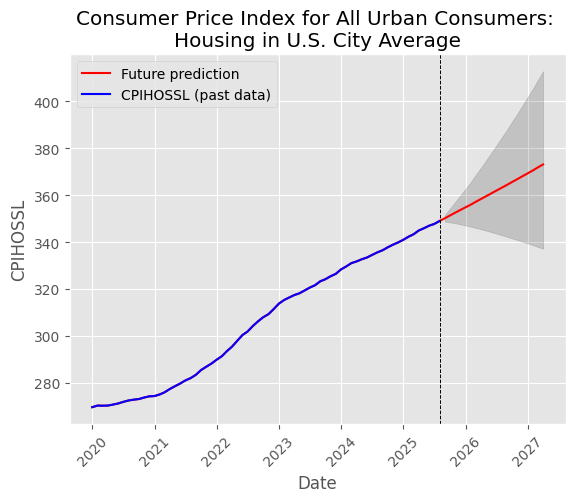

In [226]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL'], label='CPIHOSSL (past data)', color='blue')
plt.fill_between(
    confint['observation_date'],
    confint['pred_lower_ci'],
    confint['pred_upper_ci'],
    color='k', alpha=0.15
)
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('CPIHOSSL')
plt.title('Consumer Price Index for All Urban Consumers: \nHousing in U.S. City Average')
plt.xticks(rotation=45)
plt.legend();

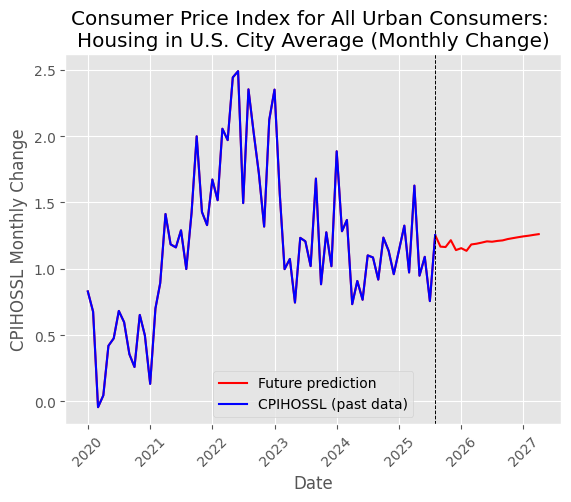

In [173]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL_delta'], label='CPIHOSSL (past data)', color='blue')
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('CPIHOSSL Monthly Change')
plt.title('Consumer Price Index for All Urban Consumers: \nHousing in U.S. City Average (Monthly Change)')
plt.xticks(rotation=45)
plt.legend();

### Fitting ARIMA Model

In [230]:
model = ARIMA(cpih['CPIHOSSL_log'], order=(2, 1, 13)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CPIHOSSL_log   No. Observations:                  704
Model:                ARIMA(2, 1, 13)   Log Likelihood                3350.979
Date:                Sun, 14 Sep 2025   AIC                          -6669.959
Time:                        19:06:15   BIC                          -6597.073
Sample:                             0   HQIC                         -6641.790
                                - 704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5549      0.460      1.207      0.228      -0.346       1.456
ar.L2          0.4292      0.456      0.942      0.346      -0.464       1.323
ma.L1         -0.1909      0.462     -0.413      0.679      -1.096       0.715
ma.L2         -0.2977      0.289     -1.030      0.303      -0.864       0.269
ma.L3         -0.0884      0.031     -2.855      0.004      -0.149      -0.028
ma.L4         -0.0970      0.044     -2.215      0.027      -0.183      -0.011
ma.L5         -0.0091      0.046     -0.198      0.843      -0.100       0.081
ma.L6          0.0265      0.031      0.854      0.393      -0.034       0.087
ma.L7          0.0578      0.034      1.688      0.091      -0.009       0.125
ma.L8          0.0091      0.038      0.237      0.813      -0.066       0.084
ma.L9          0.0413      0.031      1.344      0.179      -0.019       0.102
ma.L10        -0.0089      0.040     -0.219      0.827      -0.088       0.070
ma.L11         0.0334      0.036      0.933      0.351      -0.037       0.104
ma.L12        -0.1081      0.041     -2.655      0.008      -0.188      -0.028
ma.L13         0.0090      0.069      0.130      0.897      -0.127       0.145
sigma2      4.224e-06   1.07e-07     39.411      0.000    4.01e-06    4.43e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              9304.63
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [231]:
forecast = model.get_forecast(steps=15)
fcast_mean = forecast.predicted_mean
fcast_mean

704    5.858143
705    5.861329
706    5.864506
707    5.867595
708    5.870634
709    5.873484
710    5.876500
711    5.879178
712    5.882095
713    5.884834
714    5.887725
715    5.890407
716    5.893144
717    5.895813
718    5.898469
Name: predicted_mean, dtype: float64

In [236]:
forecast.conf_int()

,lower CPIHOSSL_log,upper CPIHOSSL_log
704,5.854115,5.862171
705,5.854516,5.868142
706,5.854854,5.874158
707,5.855150,5.880040
708,5.855503,5.885766
709,5.855658,5.891310
710,5.855909,5.897091
711,5.855652,5.902705
712,5.855505,5.908684
713,5.854979,5.914690


In [202]:
data_with_pred = np.append(cpih['CPIHOSSL_log'].values, fcast_mean)
data_with_pred.shape

(719,)